<a href="https://colab.research.google.com/github/Guljeren/Ml_lab/blob/main/lab_3_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
# 1. ЗАГРУЗКА ДАННЫХ
import os
import json
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi

# Создаю kaggle.json файл автоматически
kaggle_config = {
    "username": "guljeren",
    "key": "kaggle"
}

# Создаем необходимые папки
os.makedirs('/root/.config/kaggle', exist_ok=True)

# Сохраняем конфиг
with open('/root/.config/kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_config, f)

# Устанавливаем правильные права доступа
os.chmod('/root/.config/kaggle/kaggle.json', 0o600)

# Загрузка датасета
api = KaggleApi()
api.authenticate()
dataset = 'uciml/german-credit'
api.dataset_download_files(dataset, path='./data', unzip=True)

csv_files = [file for file in os.listdir('./data') if file.endswith('.csv')]
csv_path = os.path.join('./data', csv_files[0])

df = pd.read_csv(csv_path, low_memory=False)
print(f'Размер датасета: {df.shape}')

general_keywords = ['credit_risk', 'risk', 'class', 'default', 'credit', 'rating']
specific_keywords = ['credit_risk', 'risk', 'class', 'bad', 'good', 'default']

target_column = None

# Сначала ищем точное совпадение
for col in df.columns:
    if col.lower() == 'credit_risk':
        target_column = col
        break

# Если не нашли, ищем по ключевым словам
if target_column is None:
    for keyword in general_keywords:
        for col in df.columns:
            if keyword in col.lower() and df[col].count() >= 1000 and df[col].nunique() >= 2:
                target_column = col
                break
        if target_column:
            break

if target_column is None:
    for keyword in specific_keywords:
        for col in df.columns:
            if keyword in col.lower() and df[col].count() >= 1000 and df[col].nunique() >= 2:
                target_column = col
                break
        if target_column:
            break

# Если всё равно не нашли, берём подходящую колонку
if target_column is None:
    for col in df.columns:
        if df[col].count() >= 1000 and df[col].nunique() >= 2:
            target_column = col
            break

# Последний вариант
if target_column is None:
    target_column = df.columns[-1]

print(f'Целевой признак: {target_column}')
print(f'Данных: {df[target_column].count()}')
print(f'Уникальных значений: {df[target_column].nunique()}')
print(f'Пример данных:\n{df[target_column].value_counts().head()}')

df = df.rename(columns={target_column: 'credit_risk'})

Dataset URL: https://www.kaggle.com/datasets/uciml/german-credit
Размер датасета: (1000, 10)
Целевой признак: Credit amount
Данных: 1000
Уникальных значений: 921
Пример данных:
Credit amount
1275    3
1262    3
1478    3
1393    3
1258    3
Name: count, dtype: int64


In [39]:
print(df.columns.tolist())

['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'credit_risk', 'Duration', 'Purpose']


Целевой признак из лаб_1: 'Age'
Доступные колонки: ['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'credit_risk', 'Duration', 'Purpose']


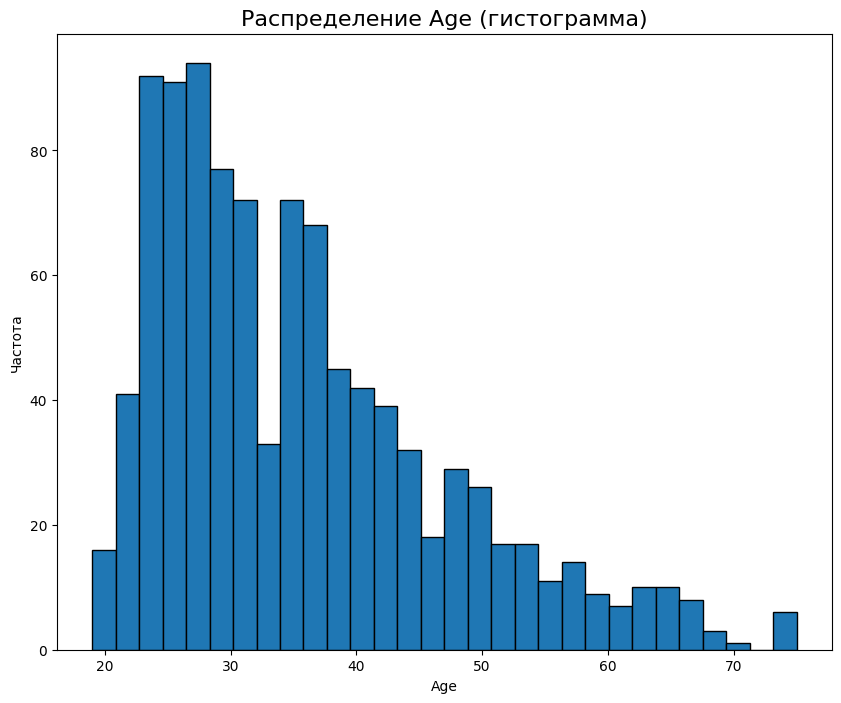

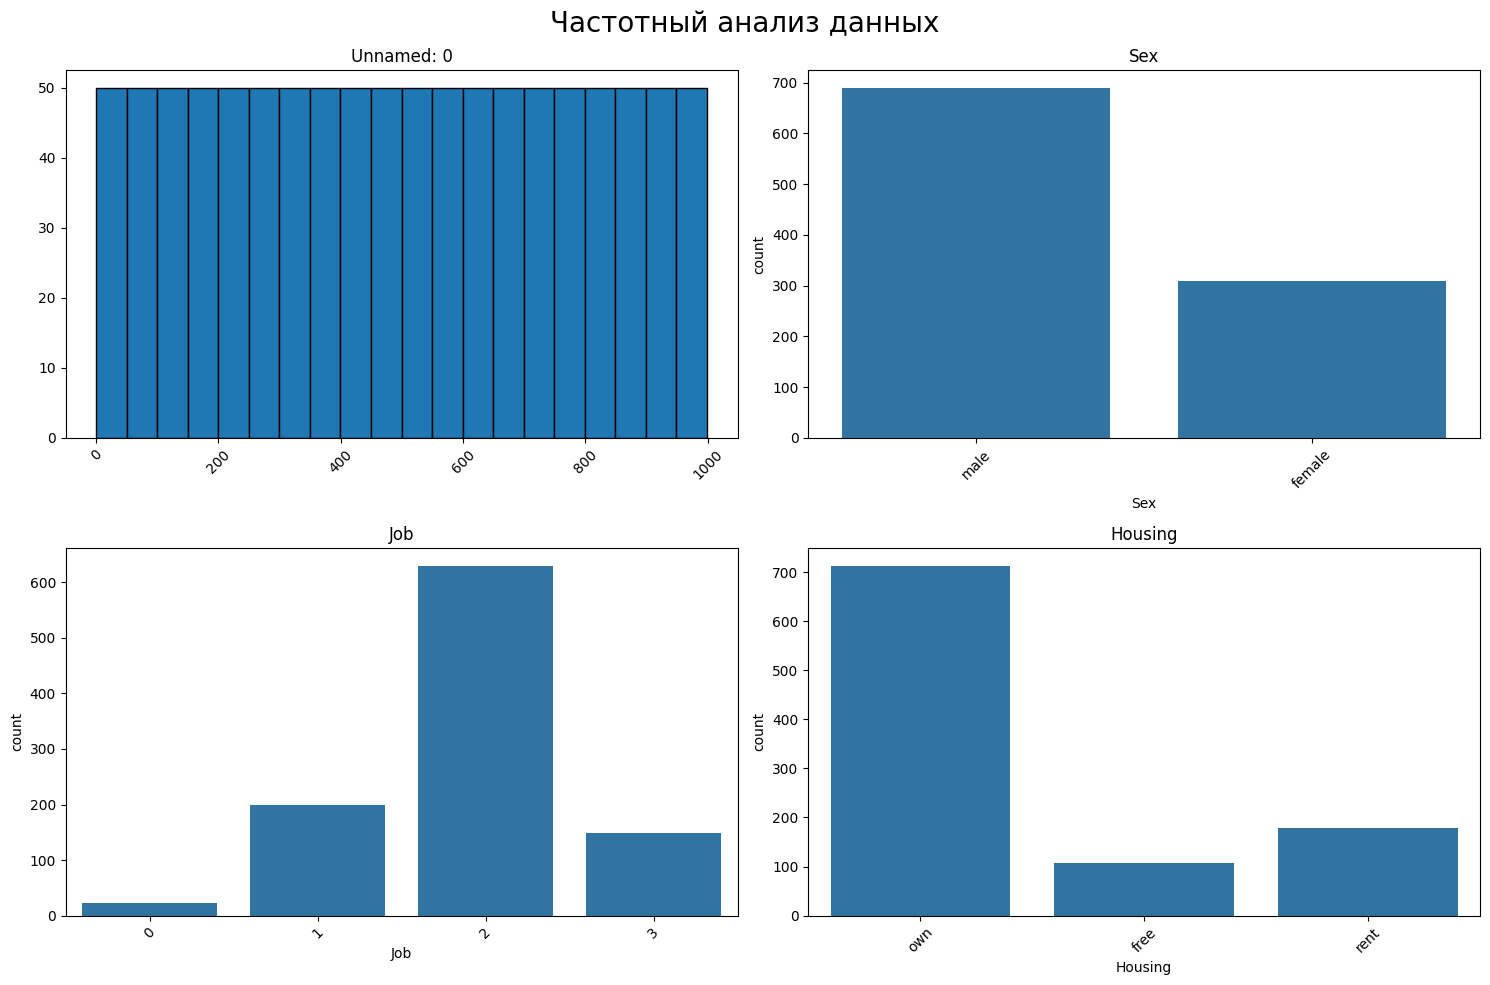

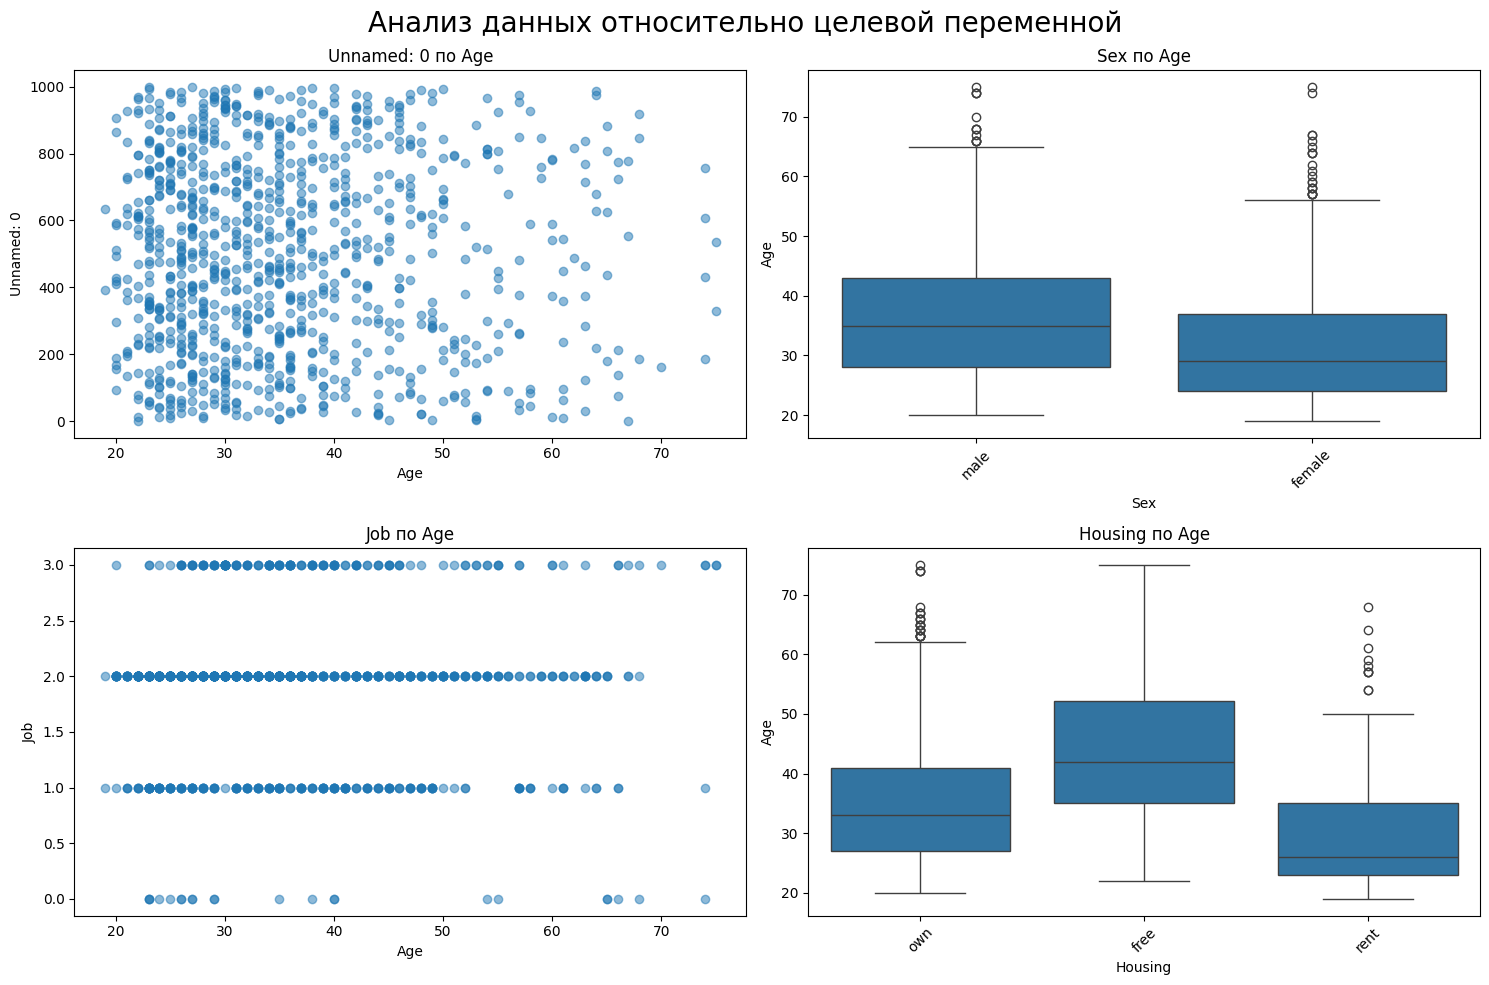

In [41]:
# 2. ВИЗУАЛИЗАЦИИ
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ПРОВЕРЯЕМ  КОЛОНКУ по лаб_1
print(f"Целевой признак из лаб_1: '{target_column}'")
print(f"Доступные колонки: {list(df.columns)}")

# Если target_column не найден в df
if target_column not in df.columns:
    # Убираем пробелы и проверяем
    target_clean = target_column.replace(' ', '_')
    if target_clean in df.columns:
        target_column = target_clean
    else:
        # Ищем ТОЧНО ТУ ЖЕ колонку что в лаб_1
        # Варианты названий для 'Credit amount'
        possible_names = ['Credit amount', 'credit_amount', 'Credit_Amount',
                         'Amount', 'CreditAmount', 'credit amount']

        for name in possible_names:
            if name in df.columns:
                target_column = name
                break

        # Если не нашли, используем исходное название из лаб_1
        print(f"Используем: '{target_column}'")

# ПРОВЕРКА: убедимся что колонка существует
if target_column not in df.columns:
    # Создадим простой график с первой колонкой
    print(f"Колонка '{target_column}' не найдена. Используем 'Age'")
    target_column = 'Age'

# 1. График распределения целевого признака
plt.figure(figsize=(10,8))

# Проверяем тип данных целевой колонки
if df[target_column].dtype in ['int64', 'float64'] and df[target_column].nunique() > 10:
    # Для числовых данных с многими уникальными значениями - гистограмма
    plt.hist(df[target_column].dropna(), bins=30, edgecolor='black')
    plt.title(f'Распределение {target_column} (гистограмма)', fontsize=16)
    plt.xlabel(target_column)
    plt.ylabel('Частота')
else:
    # Для категориальных или данных с малым числом уникальных значений - countplot
    sns.countplot(x=target_column, data=df)
    plt.title(f'Распределение {target_column}', fontsize=16)

plt.show()

# 2. Частотный анализ других признаков
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Частотный анализ данных', fontsize=20)

# Берём 4 другие колонки (не целевую)
other_columns = [col for col in df.columns if col != target_column][:4]

for idx, col in enumerate(other_columns):
    row, col_idx = divmod(idx, 2)

    # Проверяем тип данных для выбора графика
    if df[col].dtype in ['int64', 'float64'] and df[col].nunique() > 10:
        axes[row, col_idx].hist(df[col].dropna(), bins=20, edgecolor='black')
    else:
        sns.countplot(x=col, data=df, ax=axes[row, col_idx])

    axes[row, col_idx].set_title(col)
    axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 3. Анализ относительно целевой переменной
fig, axes = plt.subplots(2, 2, figsize=(15,10))
fig.suptitle('Анализ данных относительно целевой переменной', fontsize=20)

for idx, col in enumerate(other_columns):
    row, col_idx = divmod(idx, 2)

    # Для числовых признаков - boxplot
    if df[col].dtype in ['int64', 'float64']:
        if df[target_column].nunique() <= 10:  # Если целевая категориальная
            sns.boxplot(x=target_column, y=col, data=df, ax=axes[row, col_idx])
        else:
            # Если обе числовые - scatter plot
            axes[row, col_idx].scatter(df[target_column], df[col], alpha=0.5)
            axes[row, col_idx].set_xlabel(target_column)
            axes[row, col_idx].set_ylabel(col)
    else:
        # Для категориальных - countplot с hue
        if df[target_column].nunique() <= 10:
            sns.countplot(x=col, hue=target_column, data=df, ax=axes[row, col_idx])
        else:
            # Если целевая числовая
            sns.boxplot(x=col, y=target_column, data=df, ax=axes[row, col_idx])

    axes[row, col_idx].set_title(f'{col} по {target_column}')
    if not df[col].dtype in ['int64', 'float64']:
        axes[row, col_idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [53]:
# 3. ПРОВЕРКА И СОЗДАНИЕ ПРОПУСКОВ
print("\nПроверка исходных данных:")
print(f"   Пропусков в данных: {df.isnull().sum().sum()}")

# Создаём искусственные пропуски если их нет
df_with_missing = df.copy()
if df_with_missing.isnull().sum().sum() == 0:
    print("2. Создаём искусственные пропуски (доп. баллы):")
    np.random.seed(42)

    # Выбираем числовые колонки
    numeric_cols = df_with_missing.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 0:
        for col in np.random.choice(numeric_cols, size=min(2, len(numeric_cols)), replace=False):
            n_missing = min(20, len(df_with_missing))
            missing_idx = np.random.choice(df_with_missing.index, size=n_missing, replace=False)
            df_with_missing.loc[missing_idx, col] = np.nan
            print(f"   Добавлено {n_missing} пропусков в колонку '{col}'")

    print(f"   Итоговое количество пропусков: {df_with_missing.isnull().sum().sum()}")
else:
    print("В данных уже есть пропуски")



Проверка исходных данных:
   Пропусков в данных: 577
В данных уже есть пропуски


In [51]:
# 4. ЗАПОЛНЕНИЕ ПРОПУСКОВ
print("\nЗаполнение пропусков:")
df_filled = df_with_missing.copy()

for col in df_filled.columns:
    if df_filled[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df_filled[col]):
            # Для числовых - среднее
            mean_val = df_filled[col].mean()
            df_filled[col] = df_filled[col].fillna(mean_val)
            print(f"   Колонка '{col}': заполнено {df_with_missing[col].isnull().sum()} пропусков средним значением")
        else:
            # Для категориальных - мода
            mode_val = df_filled[col].mode()[0]
            df_filled[col] = df_filled[col].fillna(mode_val)
            print(f"   Колонка '{col}': заполнено {df_with_missing[col].isnull().sum()} пропусков модой")

print(f"   Пропусков после заполнения: {df_filled.isnull().sum().sum()}")


Заполнение пропусков:
   Колонка 'Saving accounts': заполнено 183 пропусков модой
   Колонка 'Checking account': заполнено 394 пропусков модой
   Пропусков после заполнения: 0


In [50]:
# 5. ПРЕОБРАЗОВАНИЕ К ЧИСЛОВЫМ ТИПАМ
print("\nПреобразование категориальных данных в числовые:")
df_numeric = df_filled.copy()

categorical_cols = df_numeric.select_dtypes(include=['object', 'category']).columns
if len(categorical_cols) > 0:
    print(f"   Найдено категориальных колонок: {list(categorical_cols)}")

    for col in categorical_cols:
        if col != target_column:  # Целевую не трогаем
            df_numeric[col] = pd.factorize(df_numeric[col])[0]
            print(f"   Колонка '{col}' преобразована")

    # Если целевая колонка категориальная - тоже преобразуем
    if target_column in categorical_cols:
        df_numeric[target_column] = pd.factorize(df_numeric[target_column])[0]
        print(f"   Целевая колонка '{target_column}' преобразована")
else:
    print("   Категориальных колонок не найдено")

print(f"   Типы данных после преобразования:\n{df_numeric.dtypes}")


Преобразование категориальных данных в числовые:
   Найдено категориальных колонок: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
   Колонка 'Sex' преобразована
   Колонка 'Housing' преобразована
   Колонка 'Saving accounts' преобразована
   Колонка 'Checking account' преобразована
   Колонка 'Purpose' преобразована
   Типы данных после преобразования:
Unnamed: 0          int64
Age                 int64
Sex                 int64
Job                 int64
Housing             int64
Saving accounts     int64
Checking account    int64
credit_risk         int64
Duration            int64
Purpose             int64
dtype: object


In [49]:
# 6. НОРМАЛИЗАЦИЯ/СТАНДАРТИЗАЦИЯ
print("\n. Нормализация числовых признаков:")
from sklearn.preprocessing import StandardScaler

# Выбираем числовые колонки для нормализации
numeric_to_scale = df_numeric.select_dtypes(include=[np.number]).columns
# Убираем целевую переменную из нормализации
if target_column in numeric_to_scale:
    numeric_to_scale = numeric_to_scale.drop(target_column)

if len(numeric_to_scale) > 0:
    print(f"   Нормализуем колонки: {list(numeric_to_scale)}")

    scaler = StandardScaler()
    df_normalized = df_numeric.copy()
    df_normalized[numeric_to_scale] = scaler.fit_transform(df_numeric[numeric_to_scale])

    # Проверка нормализации
    print("   Проверка нормализации (первые 5 строк):")
    print(df_normalized[numeric_to_scale].head())
else:
    df_normalized = df_numeric.copy()
    print("   Нет числовых колонок для нормализации")


. Нормализация числовых признаков:
   Нормализуем колонки: ['Unnamed: 0', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'credit_risk', 'Duration', 'Purpose']
   Проверка нормализации (первые 5 строк):
   Unnamed: 0       Sex       Job   Housing  Saving accounts  \
0   -1.730320 -0.670280  0.146949 -0.598201        -0.476912   
1   -1.726856  1.491914  0.146949 -0.598201        -0.476912   
2   -1.723391 -0.670280 -1.383771 -0.598201        -0.476912   
3   -1.719927 -0.670280  0.146949  0.685493        -0.476912   
4   -1.716463 -0.670280  0.146949  0.685493        -0.476912   

   Checking account  credit_risk  Duration   Purpose  
0         -0.653831    -0.745131 -1.236478 -1.286402  
1          1.001437     0.949817  2.248194 -1.286402  
2         -0.653831    -0.416562 -0.738668 -0.672661  
3         -0.653831     1.634247  1.750384 -0.058919  
4         -0.653831     0.566664  0.256953  0.554822  


In [45]:
# 7. ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИ
print("\n Подготовка данных для модели:")
X = df_normalized.drop(columns=[target_column])
y = df_normalized[target_column]

print(f"   Признаки (X): {X.shape}")
print(f"   Целевая переменная (y): {y.shape}")



 Подготовка данных для модели:
   Признаки (X): (1000, 9)
   Целевая переменная (y): (1000,)


In [48]:
# 8. ИТОГОВАЯ ПРОВЕРКА
print(f"\nВсе данные готовы для на модель машинного обучения")
print(f"Размерность: {X.shape[0]} samples, {X.shape[1]} features")


Все данные готовы для на модель машинного обучения
Размерность: 1000 samples, 9 features
